### This is very far from my original planned architecture a lot of modifications are still to be made



What the code is currently doing:
- 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from typing import Union
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import timm
import glob

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class VIT_S_16(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(
            "vit_small_patch16_224", pretrained=False, num_classes=0, global_pool=""
        )

    def forward(self, x):
        x = self.backbone(x)
        return x

In [5]:
# DINO like structure with noise instead of masking for x1 and x2, the goal is to have the representation of the clean iamge to be the same as itself with additional guassian noise added on it
def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather constants for specific timesteps t."""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)


class DINODiffusionTrainer:
    def __init__(
        self,
        student: nn.Module,
        teacher: nn.Module,
        predictor: nn.Module,
        device: torch.device,
        n_steps=1000,
        beta_start=1e-4,
        beta_end=0.02,
        momentum=0.996,
    ):
        self.student = student
        self.teacher = teacher
        self.predictor = predictor
        self.device = device
        self.momentum = momentum

        # Initialize teacher with student weights
        self.teacher.load_state_dict(self.student.state_dict())
        # Freeze teacher
        for p in self.teacher.parameters():
            p.requires_grad = False

        # Diffusion parameters
        self.n_steps = n_steps
        self.betas = torch.linspace(beta_start, beta_end, n_steps).to(device)
        self.alphas = 1.0 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def update_teacher(self):
        """EMA update for teacher network"""
        with torch.no_grad():
            for param_s, param_t in zip(
                self.student.parameters(), self.teacher.parameters()
            ):
                param_t.data.mul_(self.momentum).add_(
                    param_s.data * (1 - self.momentum)
                )

    def forward_diffusion(self, x_0: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        """Sample from q(x_t | x_0)"""
        sqrt_alpha_bar = gather(torch.sqrt(self.alpha_bars), t)
        sqrt_one_minus_alpha_bar = gather(torch.sqrt(1.0 - self.alpha_bars), t)

        noise = torch.randn_like(x_0)
        return sqrt_alpha_bar * x_0 + sqrt_one_minus_alpha_bar * noise, noise

    def loss(self, x_0: torch.Tensor):
        """DINO-Diffusion loss function"""
        # Sample random timesteps
        t = torch.randint(
            self.n_steps // 4,
            self.n_steps // 4 * 3,
            (x_0.shape[0],),
            device=self.device,
        )

        # Create noisy versions
        x_t, noise = self.forward_diffusion(x_0, t)

        # Get representations
        with torch.no_grad():
            # Teacher processes clean image
            teacher_repr = self.teacher(x_0)
            # Use CLS token as global representation
            teacher_global = teacher_repr[:, 0]  # [B, D]
            # Center and sharpen teacher output (DINO-specific)
            teacher_global = F.softmax(teacher_global / 0.07, dim=-1)

        # Student processes noisy image
        student_repr = self.student(x_t)
        student_global = student_repr[:, 0]  # [B, D]
        # Predictor transforms student output
        predicted_repr = self.predictor(student_global)

        # DINO loss: cross-entropy between predicted and teacher distributions
        loss = F.cross_entropy(predicted_repr, teacher_global)

        return loss

In [6]:
def save_image(im, path):
    Image.fromarray(im).save(path)

In [7]:
def load_latest_checkpoint(
    student, teacher, predictor, optimizer, checkpoint_dir="checkpoints"
):
    # Get list of checkpoint files
    checkpoint_files = glob.glob(os.path.join(checkpoint_dir, "checkpoint_*.pth"))
    if not checkpoint_files:
        print("No checkpoints found, starting from scratch.")
        return 0  # start at step 0

    # Extract global_step from filenames
    steps = [
        int(os.path.basename(f).split("_")[1].split(".")[0]) for f in checkpoint_files
    ]
    max_step = max(steps)
    latest_file = os.path.join(checkpoint_dir, f"checkpoint_{max_step}.pth")

    print(f"Loading checkpoint {latest_file}")
    checkpoint = torch.load(
        latest_file, map_location="cuda" if torch.cuda.is_available() else "cpu"
    )

    # Load model & optimizer states
    student.load_state_dict(checkpoint["student_state_dict"])
    teacher.load_state_dict(checkpoint["teacher_state_dict"])
    predictor.load_state_dict(checkpoint["predictor_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    return checkpoint["global_step"]

In [15]:
# Main

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
np.random.seed(42)

# Create directories
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("samples", exist_ok=True)

# Configuration
config = {
    "n_steps": 1000,
    "student_momentum": 0.996,
    "batch_size": 128,  # Increased from 1 for better training
    "epochs": 100,  # Increased for meaningful training
    "save_interval": 1000,  # Save every 1000 steps
    "learning_rate": 1e-4,
    "accumulation_steps": 1,  # Gradient accumulation steps
    "image_size": 224,  # ViT-S/16 expects 224x224 images
}

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize models
student = VIT_S_16().to(device)
teacher = VIT_S_16().to(device)
embed_dim = student.backbone.num_features
predictor = nn.Sequential(
    nn.Linear(embed_dim, 4 * embed_dim),
    nn.GELU(),
    nn.Linear(4 * embed_dim, embed_dim),
).to(device)

# Print parameter count
print(f"Student params: {sum(p.numel() for p in student.parameters())}")
print(f"Teacher params: {sum(p.numel() for p in teacher.parameters())}")
print(f"Predictor params: {sum(p.numel() for p in predictor.parameters())}")

# Initialize trainer
trainer = DINODiffusionTrainer(
    student=student,
    teacher=teacher,
    predictor=predictor,
    device=device,
    n_steps=config["n_steps"],
)

# Setup optimizer (only optimize student and predictor)
optimizer = optim.AdamW(
    list(student.parameters()) + list(predictor.parameters()),
    lr=config["learning_rate"],
    weight_decay=0.05,
)

global_step = load_latest_checkpoint(
    student, teacher, predictor, optimizer, checkpoint_dir="checkpoints"
)
print(f"Resuming from global step {global_step}")

# Setup dataset and dataloader
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Recommended datasets for training:
# 1. ImageNet (large-scale, best results)
# 2. Places365 (scene understanding)
# 3. COCO (objects in context)
# 4. FFHQ (high-quality faces)

dataset = datasets.CocoDetection(
    root="./data",
    annFile="./data/instances_train2017.json",
    transform=transform,
)


dataloader = DataLoader(
    dataset,
    batch_size=config["batch_size"],
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

# Training loop
student.train()
teacher.eval()  # Teacher is always in eval mode
predictor.train()

global_step = 0
for epoch in range(config["epochs"]):
    for batch_idx, (images, _) in enumerate(dataloader):
        images = images.to(device)

        # Forward pass and loss calculation
        loss = trainer.loss(images)

        # Normalize loss for gradient accumulation
        loss = loss / config["accumulation_steps"]

        # Backward pass
        loss.backward()

        # Optimize only after accumulation steps
        if (batch_idx + 1) % config["accumulation_steps"] == 0:
            optimizer.step()
            optimizer.zero_grad()

            # Update teacher with EMA
            trainer.update_teacher()

        # Logging
        if global_step % 100 == 0:
            print(
                f"Epoch: {epoch}, Step: {global_step}, Loss: {loss.item() * config['accumulation_steps']}"
            )

        if global_step % 200 == 0:  # every few steps
            with torch.no_grad():
                t = torch.full(
                    (images.shape[0],),
                    config["n_steps"] // 4 * 3,
                    device=device,
                    dtype=torch.long,
                )
                x_t, _ = trainer.forward_diffusion(images, t)
                teacher_repr = trainer.teacher(images)[:, 0]
                student_repr = trainer.student(x_t)[:, 0]
                sim = F.cosine_similarity(teacher_repr, student_repr, dim=-1).mean()
            print(f"Step {global_step}: Cosine Sim = {sim.item():.4f}")

        # Save checkpoint
        if global_step > 0 and global_step % config["save_interval"] == 0:
            checkpoint = {
                "global_step": global_step,
                "student_state_dict": student.state_dict(),
                "teacher_state_dict": teacher.state_dict(),
                "predictor_state_dict": predictor.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
            }
            torch.save(checkpoint, f"checkpoints/checkpoint_{global_step}.pth")

        global_step += 1

print("Training completed!")

Using device: cuda
Student params: 21665664
Teacher params: 21665664
Predictor params: 1181568
No checkpoints found, starting from scratch.
Resuming from global step 0
loading annotations into memory...


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
batch_size = 128
lr = 1e-3
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

_ = load_latest_checkpoint(
    student, teacher, predictor, optimizer, checkpoint_dir="checkpoints"
)
# ---------------------------
# Dataset
# ---------------------------
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),  # match ViT input size
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4
)

# ---------------------------
# Feature extractor (student)
# ---------------------------
student.eval()  # freeze student
for param in student.parameters():
    param.requires_grad = False

embed_dim = student.backbone.num_features

# ---------------------------
# Linear classifier
# ---------------------------
classifier = nn.Linear(embed_dim, 10).to(device)  # 10 classes for CIFAR-10
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=lr)

# ---------------------------
# Training loop
# ---------------------------
for epoch in range(epochs):
    classifier.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            features = student(images)[:, 0]  # CLS token

        outputs = classifier(features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
        total_samples += images.size(0)

    train_acc = total_correct / total_samples
    train_loss = total_loss / total_samples
    print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")

# ---------------------------
# Evaluation
# ---------------------------
classifier.eval()
total_correct, total_samples = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        features = student(images)[:, 0]
        outputs = classifier(features)
        total_correct += (outputs.argmax(1) == labels).sum().item()
        total_samples += images.size(0)

test_acc = total_correct / total_samples
print(f"Test Accuracy: {test_acc:.4f}")

Loading checkpoint checkpoints/checkpoint_3000.pth
Epoch 1/10 - Loss: 2.0051, Acc: 0.2616
Epoch 2/10 - Loss: 1.9625, Acc: 0.2763
Epoch 3/10 - Loss: 1.9493, Acc: 0.2831
Epoch 4/10 - Loss: 1.9412, Acc: 0.2847
Epoch 5/10 - Loss: 1.9347, Acc: 0.2901
Epoch 6/10 - Loss: 1.9286, Acc: 0.2909
Epoch 7/10 - Loss: 1.9240, Acc: 0.2918
Epoch 8/10 - Loss: 1.9219, Acc: 0.2939
Epoch 9/10 - Loss: 1.9166, Acc: 0.2967
Epoch 10/10 - Loss: 1.9135, Acc: 0.2971
Test Accuracy: 0.3038


# Results

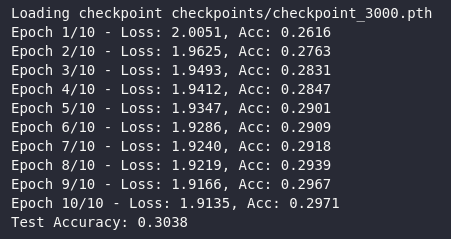